In [2]:
import Pkg
Pkg.activate("scripts") # Change this to "." incase your "scripts" is already your working directory

In [2]:
using OrdinaryDiffEq, Flux, Optimisers, ParameterSchedulers, Random

# Not registered packages, add them manually (see comment in the Readme.md)
using LVModels, NODEData

In [3]:
Random.seed!(1234) # We set a random seed to have reproducible results

TaskLocalRNG()

In [4]:
# Define the 3D Lotka-Volterra model
function lotka_volterra_3d!(du, u, p, t)
    x, y, z = u
    α, β, γ, δ, η, ζ, κ = p  
    
    du[1] = α*x - β*x*y
    du[2] = -γ*y + δ*x*y - η*y*z
    du[3] = -ζ*z + κ*y*z
end

# Model parameters and initial conditions
p = Float32.([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
tspan, dt = (0f0, 50f0), 0.1f0
u0 = Float32.([1.2, 1.8, 2.4])

# Solve the ODE
sol = solve(ODEProblem(lotka_volterra_3d!, u0, tspan, p), Tsit5(), saveat=dt)

# Create dataset with randomly missing values 
t, X_sparse, mask = sparsify_data(sol) # 0% missing values for species z
train, valid = NODEDataloader(X_sparse, t, 2; valid_set=0.2)

(NODEData{Matrix{Float32},Int64} with 400 batches with length 2, NODEData{Matrix{Float32},Int64} with 99 batches with length 2)

In [5]:
# Define neural ODE model
N_weights = 64
U_nn = Chain(Dense(3, N_weights, swish), Dense(N_weights, N_weights, swish), Dense(N_weights, 3))
θ, U_re = Flux.destructure(U_nn)
p_ln = LearnableParams(θ, Float32[0.0]) # Learnable decay parameter

function neural_ode(u, p_ln::LearnableParams, t)
    x, y, z = u
    U = U_re(p_ln.θ)(u)
    [1.0f0 * x + U[1], -1.0f0 * y + U[2], -1.0f0 * z + U[3]]
end

model = NDE(ODEProblem(neural_ode, u0, (0f0, dt), p_ln); reltol=1f-5, dt=dt)

NDE{LearnableParams{Vector{Float32}}, ODEProblem{Vector{Float32}, Tuple{Float32, Float32}, false, LearnableParams{Vector{Float32}}, ODEFunction{false, SciMLBase.AutoSpecialize, typeof(neural_ode), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, Base.Pairs{Symbol, Float32, Tuple{Symbol, Symbol}, @NamedTuple{reltol::Float32, dt::Float32}}}(LearnableParams{Vector{Float32}}(Float32[0.117600754, 0.015438834, 0.20252457, 0.2038755, 0.09925751, 0.014332914, 0.21570396, -0.29156438, 0.18967892, -0.05642094  …  -0.026928946, 0.23064733, 0.296209, -0.29601738, 0.28836566, -0.20942383, -0.071439825, 0.0, 0.0, 0.0], Float32[0.0]), ODEProblem{Vector{

In [6]:
# Training setup
opt_state = Optimisers.setup(Optimisers.Adam(1f-3), model)

τ_min, τ_max, epochs = 2, 8, 20
NN_train, NN_valid = min(100, length(train)), min(100, length(valid))
scheduler = CosAnneal(1f-3, 0f0, epochs, false)

CosAnneal{Float32, Int64}(0.001f0, 0.0f0, 20, false)

In [7]:
# Training loop 
Train = false
if Train
    println("Training started...")
    for i_τ in τ_min:τ_max
        train_τ = NODEDataloader(X_sparse, t, i_τ)
        @info "Batch size = $(i_τ)"

        for epoch in 1:epochs
            η = Float32(scheduler(epoch))
            Optimisers.adjust!(opt_state, η)

            for (batch_t, batch_data) in train_τ
                batch_mask = get_mask_for_batch(batch_t, mask, t[1], dt)
                Flux.train!(model, [(batch_t, batch_data)], opt_state) do m, bt, bd
                    loss(m, (bt, bd), bd, batch_mask; λ2=1f-5)
                end
            end

            train_loss = mean([loss(model, train[i], train[i][2], get_mask_for_batch(train[i][1], mask, t[1], dt)) for i in 1:NN_train])
            valid_loss = mean([loss(model, valid[i], valid[i][2], get_mask_for_batch(valid[i][1], mask, t[1], dt)) for i in 1:NN_valid])
            @printf("Epoch %3d | LR: %.2e | Train Loss: %.4f | Valid Loss: %.4f\n", epoch, η, train_loss, valid_loss)

        end
    end
end

In [8]:
# Prediction for the trained NODE
@load "trained NODEs\\lv_3d_scenario1.jld2" model # Load the trained model; path relative to scripts

train_70 = NODEDataloader(X_sparse, t, 70) # Training batches of size 70 for L2 error plot
mask1 = X_sparse[3, :] .!= 0  # Logical mask for nonzero elements
# Using β = p[2], δ = p[4], η = p[5], and κ = p[7]
U_truth1 = -p[2] .* X_sparse[1, mask1] .* X_sparse[2, mask1]
U_truth2 = p[4] .* X_sparse[1, mask1] .* X_sparse[2, mask1] .- p[5] .* X_sparse[2, mask1] .* X_sparse[3, mask1]
U_truth3 = p[7] .* X_sparse[2, mask1] .* X_sparse[3, mask1]
U_truth = vcat(U_truth1', U_truth2', U_truth3')

plt_traj, plt_interaction, plt_l2_error, plt_re = plot_model_performance(sol, t, X_sparse, train_70, model, U_re, U_truth, mask, dt)

(Plot{Plots.GRBackend() n=6}, Plot{Plots.GRBackend() n=6}, Plot{Plots.GRBackend() n=1}, Plot{Plots.GRBackend() n=6})

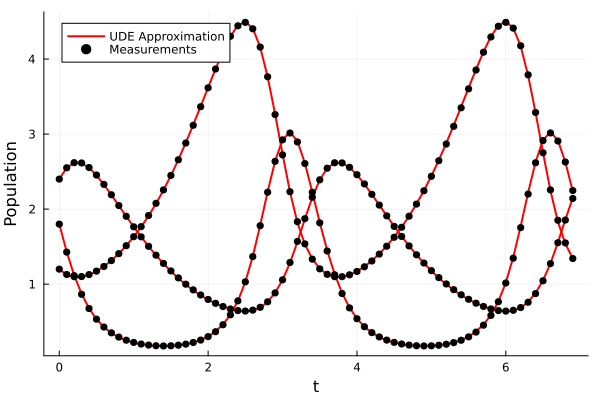

In [9]:
display(plt_traj)

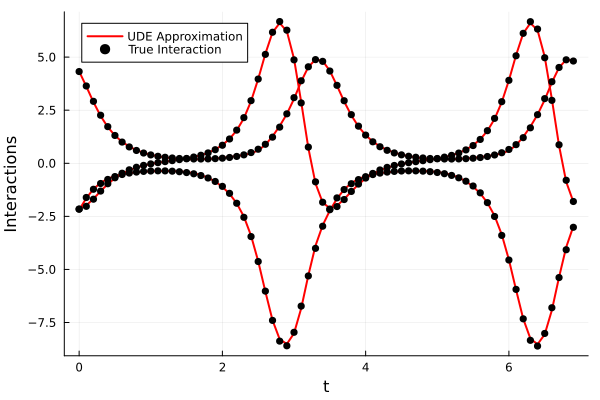

In [10]:
display(plt_interaction)

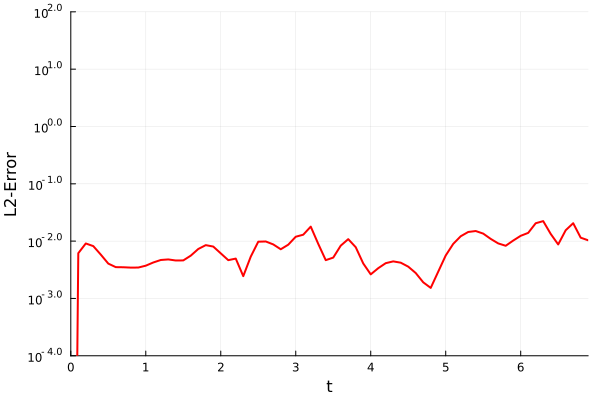

In [11]:
display(plt_l2_error)

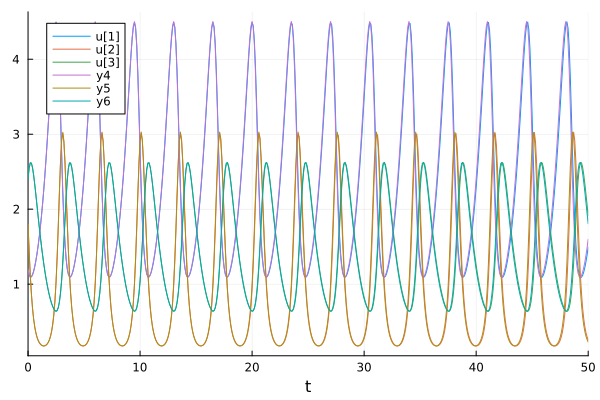

In [12]:
display(plt_re)

In [13]:
# Extract learned interactions from the neural network
mlp = U_re(model.p.θ)
dx = mlp(X_sparse)

3×501 Matrix{Float32}:
 -2.20018  -1.64343  -1.21613  -0.921066  …  -0.466041  -0.425546  -0.397326
 -2.11801  -1.98649  -1.67402  -1.31239      -0.336858  -0.210328  -0.114036
  4.32847   3.62194   2.88017   2.22772       0.802615   0.632982   0.505685

In [14]:
# Perform symbolic regression using the trained NODE
hall_of_fame, pareto_frontiers = perform_symbolic_regression(X_sparse, dx)
display(pareto_frontiers[1][3].tree) 
display(pareto_frontiers[2][3].tree) 
display(pareto_frontiers[3][3].tree) 

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\adity\.julia\packages\ProgressMeter\kVZZH\src\ProgressMeter.jl:594
Evolving for 100 iterations... 100%|█████████████████████| Time: 0:03:20


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           1.031e+00  1.594e+01  y = x₂
3           5.667e-04  3.753e+00  y = x₃ * x₂
5           5.613e-04  4.750e-03  y = (x₃ * 0.99891) * x₂
7           5.613e-04  5.630e-05  y = x₂ * ((x₃ + 0.00047129) * 0.99863)
9           5.578e-04  3.102e-03  y = (x₃ * ((x₁ * -0.47864) + x₂)) + 1.3719
11          5.538e-04  3.569e-03  y = ((((x₁ * -0.51067) + x₂) * x₃) * 0.99869) + 1.4638
13          5.278e-04  2.405e-02  y = ((x₃ * ((x₃ * -0.011903) + 0.041299)) + (x₂ + -0.03180...
                                      4)) * x₃
15          4.516e-04  7.800e-02  y = (((x₂ + (((x₃ * -0.059749) + 0.28015) * x₃)) + -0.3947...
                                      6) * x₃) - -0.16221
17          4.027e-04  5.726e-02  y = (x₂ + ((((((x₃ * -0.04481) + 0.21966) * x₃) + -0.32669...
                                      ) * x₃) - -0.14201)) * x₃
19          3.75

[ Info: Final population:
[ Info: Results saved to:


(x1 * x2) * -0.99894625

x2 * (x1 - x3)

(x3 * 0.99891305) * x2